# Phase 3 Project Tanzanian Water Wells

## Binary Logistic regression Model

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_curve
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImPipeline

In [39]:
tz_data = pd.read_csv('train_data.csv')

>- Please refer to the EDA notebook for the cleaning process towards the final data.

In [40]:
data = tz_data.copy()

In [41]:
# dropping more columns for modeling
# Will be using age of well instead of constraction year for prediction
# Data's record doesn't seem important for modeling and dropping it for now
data = data.drop(['id', 'date_recorded', 'construction_year','recorded_by'], axis =1)

In [42]:
# Changing all T/F columns 
bool_columns = data.select_dtypes(include=bool).columns
data[bool_columns] = data[bool_columns].astype(int)

# Target
>- 0 = Needs Repair
>- 1 = Functional

In [43]:
data['status_group'].value_counts()

status_group
1    32259
0    27141
Name: count, dtype: int64

In [44]:
X = data.drop('status_group', axis=1)  
y = data['status_group']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 59400 non-null  object 
 1   gps_height             59400 non-null  int64  
 2   installer              59400 non-null  object 
 3   basin                  59400 non-null  object 
 4   region                 59400 non-null  object 
 5   population             59400 non-null  float64
 6   public_meeting         59400 non-null  int64  
 7   permit                 59400 non-null  int64  
 8   extraction_type_class  59400 non-null  object 
 9   management_group       59400 non-null  object 
 10  payment                59400 non-null  object 
 11  water_quality          59400 non-null  object 
 12  quantity               59400 non-null  object 
 13  source                 59400 non-null  object 
 14  source_class           59400 non-null  object 
 15  wa

# Processing 
>- setting the columns based on their features for pipeline modeling

In [47]:
cat_cols = ['installer', 'funder', 'basin', 'management_group', 'extraction_type_class', 'payment', 'water_quality', 
              'quantity', 'source', 'source_class', 'waterpoint_type_group', 'region']

num_cols = ['gps_height', 'population', 'age_of_well']
bin_cols = ['permit', 'public_meeting']

In [48]:
#A df to record results
data_results = pd.DataFrame(columns=["Model", 'va_score',"test_balanced_acc",
                                   'train_balanced_acc', 'logloss','info','param'])

>- Transforming to a pipeline with OHE, scaler, imputer and polynomial features

In [49]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
    
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures()),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent'))
])

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols),
        ('bins',binary_transformer, bin_cols)
    ])

# Dummy model
>- Dummy classifier resulted with a 0.5 balanced accuracy score
>- But similar results on test and train could mean the model is overly complex

In [51]:
Dummy_model = Pipeline(steps=[
    ('processes', preprocessor),
    ('classifier',DummyClassifier(strategy='most_frequent', random_state=42))
])

In [52]:
X_train_dum, X_val, y_train_dum, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [53]:
Dummy_model.fit(X_train_dum, y_train_dum)

Pipeline(steps=[('processes',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group',
                                                   'region']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well']),
                                                 ('bins',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['permit',
                                                   'public_meeting'])])),
                ('classifier',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [54]:
validation_score = Dummy_model.score(X_val, y_val)
validation_score

0.5430904522613065

In [55]:
baseline_neg_log_loss_cv = cross_val_score(estimator=Dummy_model, X=X_train, y=y_train, scoring="neg_log_loss")

baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
baseline_log_loss

16.535630449705295

In [56]:
y_train_1 = Dummy_model.predict(X_train)
y_test_pred1= Dummy_model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_1)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred1)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_1)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred1)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.541233227800392
Test Accuracy: 0.546831955922865

Balanced Accuracy:
Train Accuracy: 0.5
Test Accuracy: 0.5


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8883
           1       0.55      1.00      0.71     10719

    accuracy                           0.55     19602
   macro avg       0.27      0.50      0.35     19602
weighted avg       0.30      0.55      0.39     19602



/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

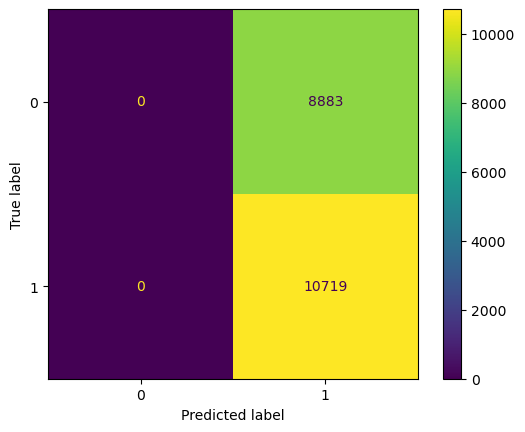

In [57]:
print(classification_report(y_test, y_test_pred1)) 
cm = confusion_matrix(y_test, y_test_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Text(0.5, 0, 'False Positive Rate')

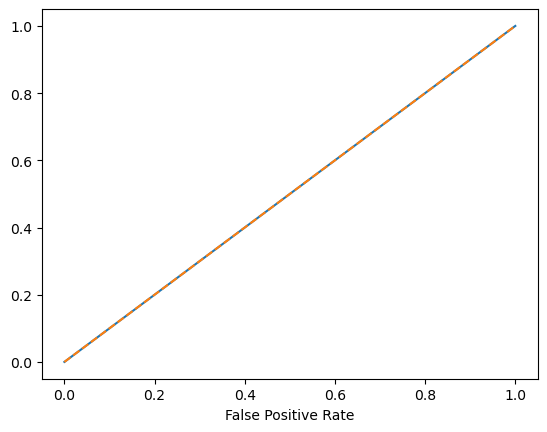

In [58]:
probs = Dummy_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

In [59]:
results_1 = pd.DataFrame({       
     "Model": ['Dummyreggressor'],
      "test_balanced_acc": [0.5], 
       'train_balanced_acc' : [0.5],
    'logloss':[16.53],
               'info' : ['baseline'],
    'param':['Random_state=42, stg=Most_frequent']
})
data_results = pd.concat([data_results, results_1], ignore_index =True)

## Logistic Regression fsm
>- First simple model with random_state 42

In [60]:
Model_1 = Pipeline(steps=[
    ('processes', preprocessor),
    ('classifier', LogisticRegression(random_state =42))
])

In [61]:
X_train_fsm, X_val_fsm, y_train_fsm, y_val_fsm = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [62]:
Model_1.fit(X_train_fsm, y_train_fsm)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('processes',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group',
                                                   'region']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well']),
                                                 ('bins',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['permit',
                                                   'public_meeting'])])),
                ('classifier', LogisticRegression(random_state=42))])

>- Cross validating before applying to the test values to see performance

In [63]:
validation_score = Model_1.score(X_val_fsm, y_val_fsm)
validation_score

0.7484924623115577

In [64]:
y_train_2 = Model_1.predict(X_train)
y_test_pred2= Model_1.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_2)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred2)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_2)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred2)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7486557113422785
Test Accuracy: 0.7501275380063259

Balanced Accuracy:
Train Accuracy: 0.7383787119989528
Test Accuracy: 0.7382652342189295


              precision    recall  f1-score   support

           0       0.79      0.61      0.69      8883
           1       0.73      0.86      0.79     10719

    accuracy                           0.75     19602
   macro avg       0.76      0.74      0.74     19602
weighted avg       0.76      0.75      0.74     19602



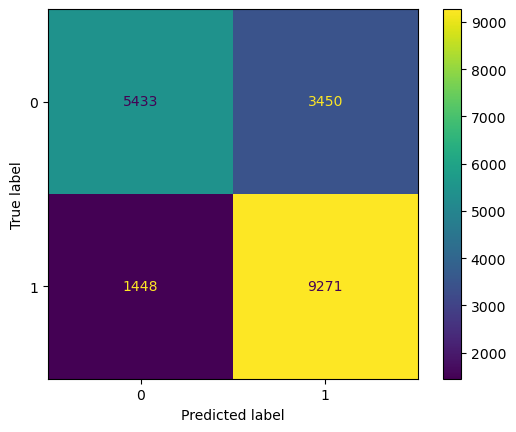

In [65]:
print(classification_report(y_test, y_test_pred2)) 
cm = confusion_matrix(y_test, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Text(0.5, 0, 'False Positive Rate')

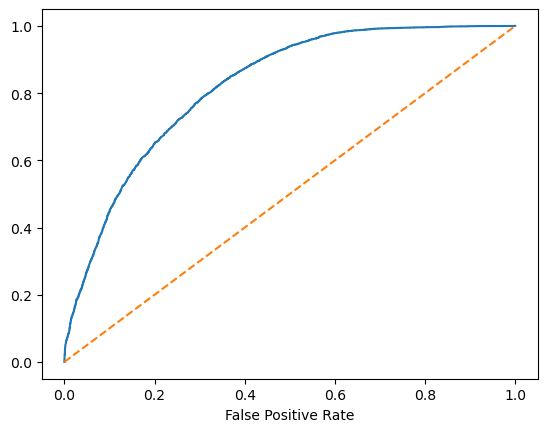

In [66]:
probs = Model_1.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

In [67]:
results_2 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.739], 
       'train_balanced_acc' : [0.738],
    'logloss':[0.50],
               'info' : ['fsm'],
    'param':['Random_state=42']
})
data_results = pd.concat([data_results, results_2], ignore_index =True)

# Grid Search
### Tuning our first model to get the best results with Grid search

In [68]:
param_grid = {
    'classifier__C': [0.0001,0.001,0.1, 1, 10],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__solver':['lbfgs', 'liblinear'],
    'classifier__max_iter': [100, 1000, 10000],  
}

In [69]:
grid_search_fsm = GridSearchCV(Model_1, param_grid, cv= 5, verbose = 2, n_jobs=-1)

In [70]:
grid_search_fsm.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['installer',
                                                                          'funder',
                                                                          'basin',
                                                                          'management_group',
                                                                          'extraction_type_class',
                                                                          'payment',
                                                                          'water_quality',
                                                                          'quantity',
                                                                          'source',
                                                                          'source_class',
                                                                          'waterpoint_type_group...
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['permit',
                                                                          'public_meeting'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.1, 1, 10],
                         'classifier__max_iter': [100, 1000, 10000],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet'],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             verbose=2)

In [71]:
best_model_fsm = grid_search_fsm.best_estimator_
best_params_fsm = grid_search_fsm.best_params_

print("best_params:", best_params_fsm)
print("best_model:", best_model_fsm)

best_params: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
best_model: Pipeline(steps=[('processes',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                       

In [72]:
validation_score = best_model_fsm.score(X_val_fsm, y_val_fsm)
validation_score

0.7484924623115577

In [73]:
validation_score = best_model_fsm.score(X_train, y_train)
validation_score

0.7481280466355094

In [74]:
y_pred_gr = best_model_fsm.predict(X_test)

In [75]:
y_train_gd = best_model_fsm.predict(X_train)
y_test_pred_gd = best_model_fsm.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_gd)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred_gd)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_gd)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred_gd)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7481280466355094
Test Accuracy: 0.7512498724619937

Balanced Accuracy:
Train Accuracy: 0.7378119668838264
Test Accuracy: 0.7394457077183911


In [76]:
baseline_neg_log_loss_cv = cross_val_score(estimator=best_model_fsm, X=X_train, y=y_train, scoring="neg_log_loss")

baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
baseline_log_loss

0.5034203217769596

              precision    recall  f1-score   support

           0       0.79      0.61      0.69      8883
           1       0.73      0.87      0.79     10719

    accuracy                           0.75     19602
   macro avg       0.76      0.74      0.74     19602
weighted avg       0.76      0.75      0.75     19602



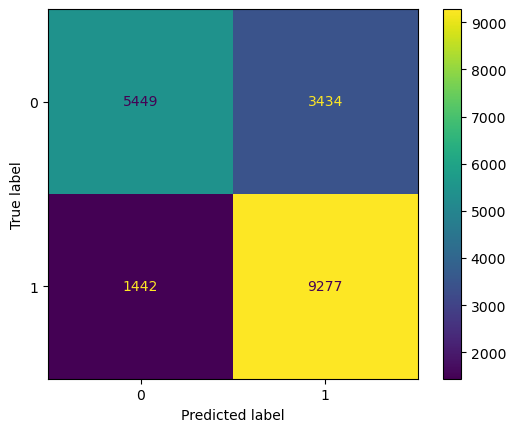

In [77]:
print(classification_report(y_test, y_test_pred_gd)) 
cm = confusion_matrix(y_test, y_test_pred_gd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Text(0.5, 0, 'False Positive Rate')

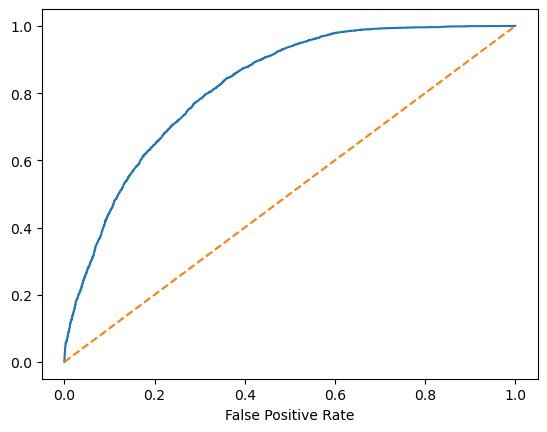

In [78]:
probs = grid_search_fsm.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

In [79]:
results_3 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.739], 
       'train_balanced_acc' : [0.737],
    'logloss':[0.50],
               'info' : ['fsm_gr'],
    'param':[best_params_fsm]
})
data_results = pd.concat([data_results, results_3], ignore_index =True)

>- The best model with grid search from the first simple model is at accuracy of 0.739

# Logistic regression With SMOTE
>- model performed well on training and the test, but the balanced accuracy is much lower meaning there's huge class imbalance
>- Below is the model with SMOTE
>- SMOTE model has more false predictions of non-functional wells and less false predictions of functional wells
>>- Compared to the simple logistic regression
>- Choosing a better model would require us identifying what our industry cares to reduce more
>>- False postives or False negatives and which we want to minimize  

In [80]:
Smote_model = ImPipeline(steps=[
    ('processes', preprocessor),
    ('sm', SMOTE(random_state = 42, n_jobs =-1)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state =42))
])

In [81]:
best_param_sm = {
    'classifier__C': [10],
    'classifier__penalty': ['l2'],
    'classifier__solver':['liblinear'],
    'classifier__max_iter': [100],  
}

In [82]:
grid_search_smote = GridSearchCV(Smote_model, best_param_sm, cv= 5, verbose = 2, n_jobs=-1)

In [83]:
grid_search_smote.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['installer',
                                                                          'funder',
                                                                          'basin',
                                                                          'management_group',
                                                                          'extraction_type_class',
                                                                          'payment',
                                                                          'water_quality',
                                                                          'quantity',
                                                                          'source',
                                                                          'source_class',
                                                                          'waterpoint_type_group...
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['permit',
                                                                          'public_meeting'])])),
                                       ('sm',
                                        SMOTE(n_jobs=-1, random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [10], 'classifier__max_iter': [100],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['liblinear']},
             verbose=2)

In [84]:
best_model_smote = grid_search_smote.best_estimator_

In [85]:
y_train_sm = grid_search_smote.predict(X_train)
y_test_pred_sm= grid_search_smote.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_sm)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred_sm)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_sm)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred_sm)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7466204331875974
Test Accuracy: 0.7483930211202938

Balanced Accuracy:
Train Accuracy: 0.7393609120403892
Test Accuracy: 0.7401982843860758


              precision    recall  f1-score   support

           0       0.76      0.65      0.70      8883
           1       0.74      0.83      0.78     10719

    accuracy                           0.75     19602
   macro avg       0.75      0.74      0.74     19602
weighted avg       0.75      0.75      0.75     19602



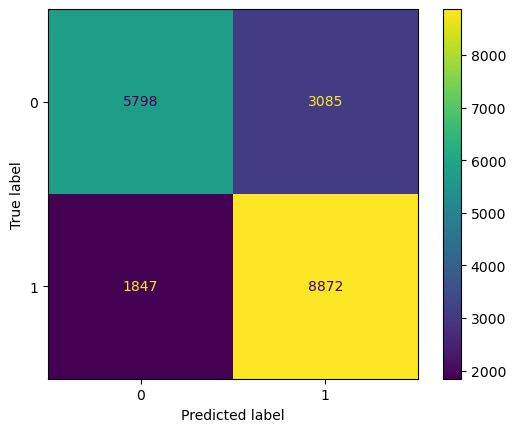

In [86]:
print(classification_report(y_test, y_test_pred_sm)) 
cm = confusion_matrix(y_test, y_test_pred_sm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Text(0.5, 0, 'False Positive Rate')

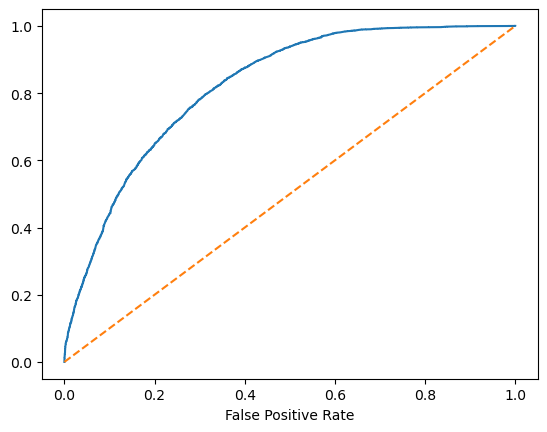

In [87]:
probs = grid_search_smote.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

In [88]:
baseline_neg_log_loss_cv = cross_val_score(estimator=grid_search_smote, X=X_train, y=y_train, scoring="neg_log_loss")

baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
baseline_log_loss

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/imblearn/over_samp

0.5058013053573036

In [89]:
results_4 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.740], 
       'train_balanced_acc' : [0.739],
    'logloss':[0.506],
               'info' : ['smote'],
    'param':[best_params_fsm]
})
data_results = pd.concat([data_results, results_4], ignore_index =True)

In [90]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19602 entries, 2980 to 11286
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 19602 non-null  object 
 1   gps_height             19602 non-null  int64  
 2   installer              19602 non-null  object 
 3   basin                  19602 non-null  object 
 4   region                 19602 non-null  object 
 5   population             19602 non-null  float64
 6   public_meeting         19602 non-null  int64  
 7   permit                 19602 non-null  int64  
 8   extraction_type_class  19602 non-null  object 
 9   management_group       19602 non-null  object 
 10  payment                19602 non-null  object 
 11  water_quality          19602 non-null  object 
 12  quantity               19602 non-null  object 
 13  source                 19602 non-null  object 
 14  source_class           19602 non-null  object 
 15  wate

In [91]:
prediction_df = pd.DataFrame({'Predicted':y_test_pred_sm})

# The best parameters and SMOTE didn't improve our models performance 
>- Let's try seeing which columns have high correlation and reduce factors affecting it's performance

In [92]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols),
        ('bin',SimpleImputer(), bin_cols)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X_train)

# Fit the linear regression model
model = LogisticRegression()
model.fit(X_preprocessed, y_train)

# Get the coefficients
coefficients = model.coef_
coefficients

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 0.92251336,  0.115376  ,  0.11234234, -0.63945548, -0.41445189,
         0.10110772, -0.36805206,  0.08510679, -0.06371694, -0.27992563,
         0.13742101,  0.1333637 ,  0.25990598, -0.44277492,  0.01172679,
         0.60172543, -0.23756456,  0.02809962, -0.34221448, -0.02473267,
         0.00607476, -0.19839866, -0.01533624, -0.08980352,  0.39433258,
        -0.37954519,  0.23544188, -0.33104576, -0.07779552,  0.83634959,
        -0.41839769, -0.71864127,  0.68486167, -0.14707574, -0.32992104,
        -0.55432917, -0.18778884,  0.2823386 ,  0.06953363,  0.55120606,
         0.04687812, -0.37845841,  0.01844146,  0.35231715, -0.1823752 ,
         0.86489682, -0.3087845 , -0.91511574, -3.21139036,  1.14991304,
         0.68910081,  0.92441805,  0.27733845, -0.48303846, -0.77118278,
        -0.86194884, -0.0805518 ,  0.59877834,  0.86878471,  0.19479783,
        -0.06641118,  0.57988179, -0.14972962, -0.33826396, -0.28140477,
         0.44904872,  0.80456767, -0.11550651,  0.0

In [93]:
data_results

,Model,va_score,test_balanced_acc,train_balanced_acc,logloss,info,param
0,Dummyreggressor,NaN,0.500,0.500,16.530,baseline,"Random_state=42, stg=Most_frequent"
1,LogisticRegression,NaN,0.739,0.738,0.500,fsm,Random_state=42
2,LogisticRegression,NaN,0.739,0.737,0.500,fsm_gr,"{'classifier__C': 10, 'classifier__max_iter': ..."
3,LogisticRegression,NaN,0.740,0.739,0.506,smote,"{'classifier__C': 10, 'classifier__max_iter': ..."


[CV] END classifier__C=0.0001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.3s
[CV] END classifier__C=0.0001, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.0001, classifier__max_iter=10000, classifier__penalty=l2, classif